In [3]:
import numpy as np 
import cv2
from cv2 import dnn
from PIL import Image
import matplotlib.pyplot as plt

In [20]:
def coloriser(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    prototext = r"Model\colorization_deploy_v2.prototxt"
    model = r"Model\colorization_release_v2.caffemodel"
    points = r"Model\pts_in_hull.npy"

    net = dnn.readNetFromCaffe(prototext, model)
    pts = np.load(points)

    class8 = net.getLayerId('class8_ab')
    conv8 = net.getLayerId('conv8_313_rh')
    pts = pts.transpose().reshape(2, 313, 1, 1)

    net.getLayer(class8).blobs = [pts.astype('float32')]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype='float32')]

    scaled = img.astype('float32') / 255.0

    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)
    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    ab = cv2.resize(ab, (img.shape[1], img.shape[0]))

    L = cv2.split(lab)[0]
    colorised = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    colorised = cv2.cvtColor(colorised, cv2.COLOR_LAB2BGR)
    colorised = np.clip(colorised, 0, 1)

    colorised = (255 * colorised).astype('uint8')

    return colorised

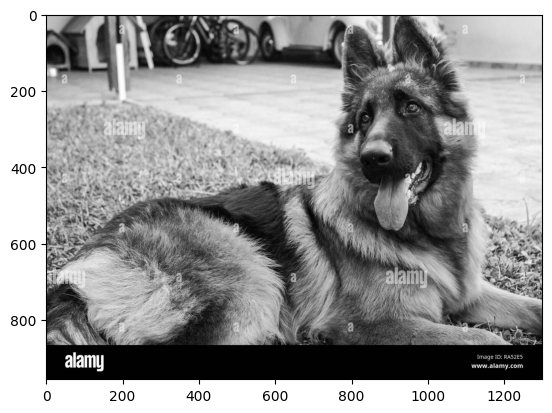

In [25]:
inp = Image.open('german shepherd.jpg')
plt.imshow(inp)

In [26]:
inp = np.array(inp)
op = coloriser(inp)
op = cv2.cvtColor(op, cv2.COLOR_RGB2BGR)

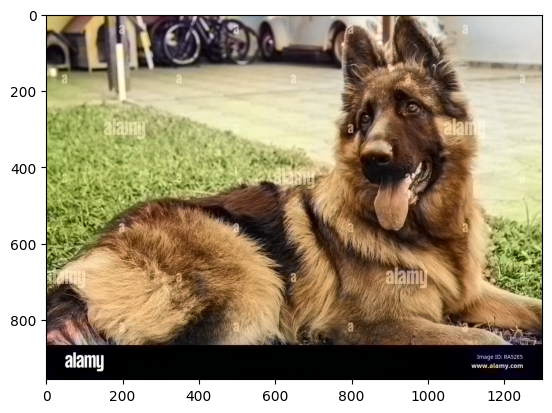

In [27]:
plt.imshow(op)